# Assignment 2.3: RNA assembly

# Learning outcomes

- Familiarity with min-cost flow reductions
- A practical understanding of assembling RNA transcripts
- Familiarity with two models of RNA assembly, and their strong and weak points
- An understanding that non-trivial algorithms are required for great practical results (not always, but often)

# Contents
### 1. Basics
    1.1 Helper functions for min-cost flows
    1.2 Visualizing flow networks

### 2. First flow reductions
    2.1 Longest path in a DAG
    2.2 Matching assembled sequences with reference sequences

### 3. RNA assembly as Minimum Path Cover
    3.1 Helper functions
    3.2 Minimum Path Cover reduction

### 4. Decomposing a flow into paths
    4.1. DP for finding a path of maximum bottleneck
    4.2. Decomposing a flow, one path at a time

### 5. RNA assembly as a (heuristic) flow decomposition

---
$^\ast$The algorithms and datasets in this assignment assume a simplified scenario: we do not start from RNA-seq reads, but directly with a (real) splicing graph. Also, there will be no noise in the coverage values that we will use for this graph.

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 0</strong></h3>

At the end of the assignment, write here how many hours it took to complete it (approximately). Write also general feedback about the assignment. What was difficult, what was easy, what was interesting, what was not, what other tasks / topics you would have liked to have in it?

#### Hours used for the tasks

I would estimate something like 10 hours.


---

#### My background
Mathematics with a computer science minor.

---

# 1. Basics

In this section we start by introducing some helper functions for min-cost flows and for visualizing the graphs. Then, we will implement the two reductions from the video lectures: longest path in a DAG, and matching novel and existing transcripts.

## 1.1. Helper functions for min-cost flows

We will use the NextworkX Python package (https://networkx.org) for representing graphs, and for solving min-cost flow problems on them. Since its `network_simplex` min-cost flow solver implementation (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.network_simplex.html#networkx.algorithms.flow.network_simplex) has a slightly different (but equivalent) interface to min-cost flows, we start with the following *wrapping* function `min_cost_flow(G, s, t)`. 

In [1]:
from itertools import count
import networkx as nx

bigNumber = 1 << 32

def min_cost_flow(G, s, t):
    
    flowNetwork = nx.DiGraph()
    
    flowNetwork.add_node(s, demand = -bigNumber)
    flowNetwork.add_node(t, demand = bigNumber)
    
    for v in G.nodes():
        if v != s and v != t:
            flowNetwork.add_node(v, demand = 0)
    
    flowNetwork.add_edge(s, t, weight = 0)

    counter = count(1) # Start an iterator given increasing integers starting from 1
    edgeMap = dict()
    
    for (x,y) in G.edges():
        z1 = str(next(counter))
        z2 = str(next(counter))
        edgeMap[(x,y)] = z1
        l = G[x][y]['l']
        u = G[x][y]['u']
        c = G[x][y]['c']
        flowNetwork.add_node(z1, demand = l)
        flowNetwork.add_node(z2, demand = -l)
        flowNetwork.add_edge(x, z1, weight = c, capacity = u)
        flowNetwork.add_edge(z1, z2, weight = 0, capacity = u)
        flowNetwork.add_edge(z2, y, weight = 0, capacity = u)

    flowCost, flowDictNet = nx.network_simplex(flowNetwork)
    
    flowDict = dict()
    for x in G.nodes():
        flowDict[x] = dict()

    for (x,y) in G.edges():
        flowDict[x][y] = flowDictNet[x][edgeMap[(x,y)]]

    return flowCost, flowDict

The function above accepts as input a `nx.DiGraph` graph `G`, a so-called *directed* graph. All graphs used in the lectures were also directed, only that we have called them simply *graphs*. It also takes two nodes, `s` (the source of the flow network) and `t` (the sink of the flow network). It assumes that the edges of the graph have attributes `l` (lowerbound), `u` (upperbound), and `c` (cost), defined for each of them. It returns the flow cost `flowCost` (i.e. a number), and a function `flowDict` (i.e. a dictionary) assigning to every edge of `G` its flow value, in a mininimum cost flow (more on this below).

Let's start with a very simple example, just to see how we can use the `min_cost_flow` function.

First, we construct a directed graph with three nodes and two edges. Notice how we assign the `l`, `u`, `c` values to the edges. The following code will construct this `flowNetwork`:

<img src='data/flowNetwork1.png'>

In [2]:
flowNetwork = nx.DiGraph()

# Adding three nodes (identified by their labels s,v,t, resp.) to the directed graph flowNetwork
flowNetwork.add_node('s')
flowNetwork.add_node('v')
flowNetwork.add_node('t')

# Adding edges between them
flowNetwork.add_edge('s', 'v', l = 1, u = 2, c = 10)
flowNetwork.add_edge('v', 't', l = 2, u = 3, c = 15)

print(f'Created a graph with {len(flowNetwork.nodes())} nodes and {len(flowNetwork.edges())} edges')

Created a graph with 3 nodes and 2 edges


The nodes, edges, and `l`, `u`, `c` values of the edges can be retrieved as follows.

In [3]:
print(flowNetwork.nodes())
print(flowNetwork.edges())
for (x,y) in flowNetwork.edges():
    print(f'l({x},{y}) = {flowNetwork[x][y]["l"]}')
    print(f'u({x},{y}) = {flowNetwork[x][y]["u"]}')
    print(f'c({x},{y}) = {flowNetwork[x][y]["c"]}')

['s', 'v', 't']
[('s', 'v'), ('v', 't')]
l(s,v) = 1
u(s,v) = 2
c(s,v) = 10
l(v,t) = 2
u(v,t) = 3
c(v,t) = 15


Finally, we can solve the min-cost flow problem on `flowNetwork`, by calling our function `min_cost_flow(flowNetwork,s,t)`. Notice that each edge of `flowNetwork` has `l`, `u`, `c` values defined when the edges of `flowNetwork` were added, and these are the ones used in the min-cost flow problem.

Notice the format of `flowDict`, which is a dictionary of dictionaries: for every node, it stores a dictionary with the out-neighbors of the node, and the min-cost flow value on the edge to that out-neighbor. For example, in this way, `flowDict['s']['v']` gives the min-cost flow value on edge `(s,v)`.

In [4]:
flowCost, flowDict = min_cost_flow(flowNetwork, 's', 't')

print(f'flowCost = {flowCost}')
print(flowDict)
print(flowDict['s']['v'])

flowCost = 50
{'s': {'v': 2}, 'v': {'t': 2}, 't': {}}
2


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 1</strong></h3>

Now it's your turn to create a flow network and solve a min-cost flow problem on it. Create a flow network `fN1` consisting of $n$ nodes, $v_1,\dots,v_n$ (for concreteness, we set `n = 10` below). For each edge $(v_i,v_{i+1}) (i \in \{1,\dots,n-1\})$, set:
- $\ell(v_i,v_{i+1}) = i$
- $u(v_i,v_{i+1}) = n$
- $c(v_i,v_{i+1}) = n-i$

Set the source of the flow network to be $v_1$ and the sink of the flow network to be $v_n$, and compute a min-cost flow on it. 

Print the min-cost flow value, and the flow value of the edge $(v_1,v_2)$.

<strong>NOTE</strong>: The node identifiers of a `nx.Digraph()` object can also be numbers. Thus, you can use `1,...,n` as identifiers. Add the nodes and edges with a `for` loop. 

In [5]:
n = 10

fN1 = nx.DiGraph()

# Create nodes
for i in range(n):
    node_i = i+1
    fN1.add_node(f'v{node_i}')

# Create edges
node_list = list(fN1.nodes)
for i in range(len(node_list)-1):
    node_i = i+1
    this_node = node_list[i]
    next_node = node_list[i+1]

    fN1.add_edge(this_node, next_node, l=node_i, u=n, c=(n-node_i))


## 1.2 Visualizing graphs

Let's now introduce some helper functions for visualizing graphs. This will make it easy to chek that the reductions we are constructing are indeed correct. 

We will use the same library `graphviz` from the previous assignment. Notice how we customize the graphviz edge labels to show the `l`,`u`,`c` attributes of the flow network. 

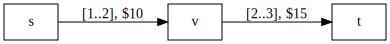

In [6]:
from graphviz import Digraph

def network2dot(nxDigraph):
    dot = Digraph()
    dot.graph_attr['rankdir'] = 'LR' # Display the graph in landscape mode
    dot.node_attr['shape'] = 'rectangle' # Rectangle nodes
    
    for (u,v) in nxDigraph.edges():
        att = nxDigraph[u][v]
        dot.edge(str(u),str(v),label=f'[{att["l"]}..{att["u"]}], ${att["c"]}')
         
    return dot

flowNetwork_dot = network2dot(flowNetwork)
flowNetwork_dot

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 2</strong></h3>

Use the function `network2dot` to visualize flow network `fN1` from the previous task.

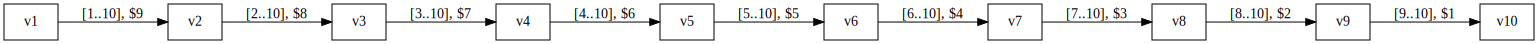

In [7]:
fN1_dot = network2dot(fN1)
fN1_dot

Let's also write a function that prints a generic graph (that doesn't necessarily have functions `l`, `u`, `c` defined for all edges), where the edges of the visualized graph are those given by a generic attribute `edgeLabels` on the edges of the `nx.Digraph`. For example, we can print just the costs of the edges of our `flowNetwork` above.

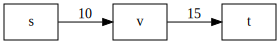

In [8]:
def graph2dot(nxDigraph, edgeLabels=None):
    dot = Digraph()
    dot.graph_attr['rankdir'] = 'LR' # Display the graph in landscape mode
    dot.node_attr['shape'] = 'rectangle' # Rectangle nodes

    for (u,v) in nxDigraph.edges():
            if edgeLabels is None:
                dot.edge(str(u),str(v)) 
            else:
                dot.edge(str(u),str(v),label=str(nxDigraph[u][v][edgeLabels]))
         
    return dot

flowNetwork_graph_dot = graph2dot(flowNetwork, edgeLabels='c')
flowNetwork_graph_dot

# 2. First flow reductions

## 2.1 Longest path in a DAG

In the video lectures, we saw a reduction from the problem of computing the longest path in a weighted DAG, from a given node $s$ to a given node $t$. Recall the following example graph from the lecture, in which the longest path is shown in blue: <img src='data/graph1.png'>

We will load this graph from a file, in the `edgelist` format of the `NetworkX` package. For our curiosity, let's see how this file looks like. 

Notice that we can run terminal commands by using the `!` sign in front, as follows.

In [9]:
!cat data/longestPathGraph.edgelist

s a {'weight':3}
s c {'weight':4}
e s {'weight':1}
e a {'weight':2}
a b {'weight':4}
a d {'weight':5}
c d {'weight':2}
b t {'weight':1}
d t {'weight':4}
d f {'weight':1}
t f {'weight':3}

We now load the graph and visualize it with our `graph2dot` function. Notice that the edges have an atribute `weight`, which we use as edge labels in the visualization.

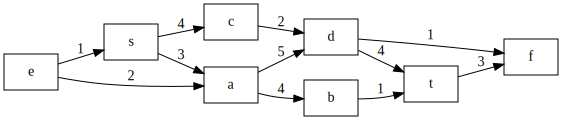

In [10]:
fg = open("data/longestPathGraph.edgelist", "rb")
G2 = nx.read_edgelist(fg, create_using=nx.DiGraph)
fg.close()

graph_dot = graph2dot(G2, edgeLabels = 'weight')
graph_dot

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 3</strong></h3>

Solve the longest (i.e. maximum weight) path problem on the graph `G2` by reducing it to a min-cost flow network. Use the same reduction as in the video lecture. 

Fill in the code fragments below to solve this problem. First visualize the flow network, then solve the problem.

<strong>NOTE</strong>: If you need to set the upper bound to some edge to $\infty$, you can set it to the variable `bigNumber` declared at the begining of the notebook. Use the function `network2dot` for visualization.

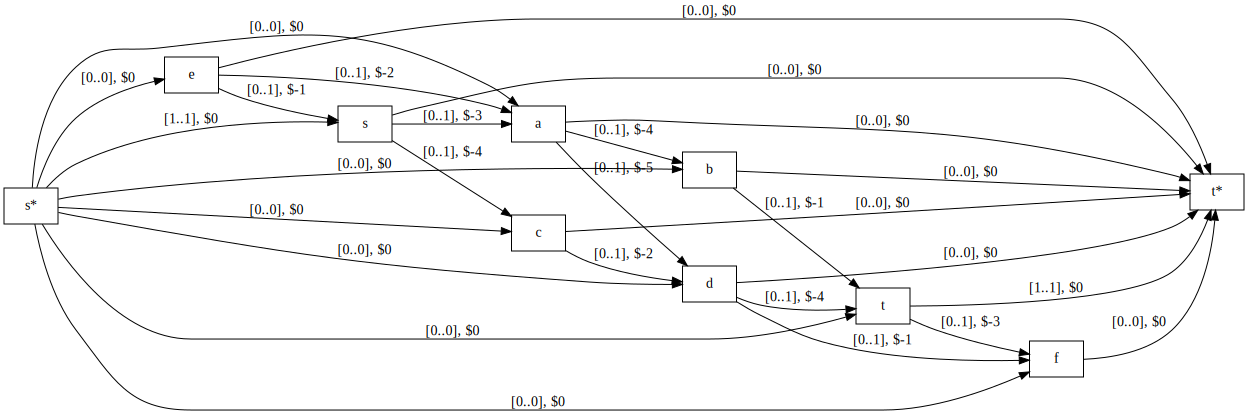

In [11]:
# We start by building a new flowNetwork from G2
fN2 = nx.DiGraph()

for v in G2.nodes():
    fN2.add_node(v)

for (u,v) in G2.edges():
    # Add the edges of G2 as edges of the flow network
    # What l, u, c values do you need to set for each?
    # Note: you can get the weight of the edge (u,v) as G2[u][v]['weight']
    
    fN2.add_edge(u, v, l=0, u=1, c=(G2[u][v]['weight'] * -1))

# We add the global source s* and the global sink t* to the flow network. 
# Note that these are new, different nodes than the nodes s and t, the start and end of the path
fN2.add_node('s*')
fN2.add_node('t*')    
    
# Add edges from s* to each node of the flowNetwork.
# What l, u, c values do you need to set for each edge (s*,v)? (keep in mind the edge (s*,s)) 
for v in G2.nodes():
    if v == 's':
        fN2.add_edge('s*', v, l=1, u=1, c=0)
    else:
        fN2.add_edge('s*', v, l=0, u=0, c=0)        

# Add edges from each node of the flowNetwork to t*.
# What l, u, c values to set for each edge (v,t*)? (keep in mind the edge (t,t*)) 
for v in G2.nodes():
    if v == 't':
        fN2.add_edge(v, 't*', l=1, u=1, c=0)        
    else:
        fN2.add_edge(v, 't*', l=0, u=0, c=0)
        
    
fN2_dot = network2dot(fN2)
fN2_dot

Solve the min-cost flow problem on `fN2` and print the **weight** of the longest path in `G2`.

In [12]:
weight, flow = min_cost_flow(fN2, 's*', 't*')

print(f'Weight of longest path: {-1*weight}')


Weight of longest path: 12


## 2.2 Matching assembled sequences with reference sequences

We now implement the second reduction from the video lectures. Remember that:
- Each node $a_i$ (assembled sequenced) has to be matched with **exactly** one reference sequence (some node $b_j$), or be classified as novel (star node).
- Each node $b_j$ (reference sequence) can be matched with **at most** one assembled sequence.
- Each allowed matching (edge) has a cost. 

The task is to find such a matching satisfying the above two conditions, of total minimum cost.

Let's begin by reading the input graph and visualizing it.

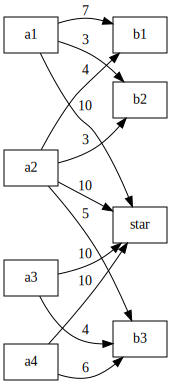

In [13]:
fg = open("data/matchingGraph.edgelist", "rb")
G3 = nx.read_edgelist(fg, create_using=nx.DiGraph)
fg.close()

graph_dot = graph2dot(G3, edgeLabels = 'cost')
graph_dot

The input file `matchingGraph.edgelist` does not contain information on what are the assembled sequences, and what are the reference sequences. However, we assume the assembled sequences are those without in-neighbors (i.e. in-degree zero), and the reference sequences are those without out-neighbors (i.e. out-degree zero). 

Also, we assume that the node 'star' represents the novel sequences, allowed to match many assembled sequences. Note that we already assigned as 10 the cost of the edges in-coming to 'star'.

In [14]:
assembledSeqs = list()
referenceSeqs = list()

for v in G3.nodes():
    if G3.in_degree(v) == 0:
        assembledSeqs.append(v)
    if G3.out_degree(v) == 0:
        referenceSeqs.append(v)

print(assembledSeqs)
print(referenceSeqs)

['a1', 'a2', 'a3', 'a4']
['b1', 'b2', 'star', 'b3']


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 4</strong></h3>

Build and visualize the min-cost flow reduction from the video lecture, by filling the following missing code fragments.

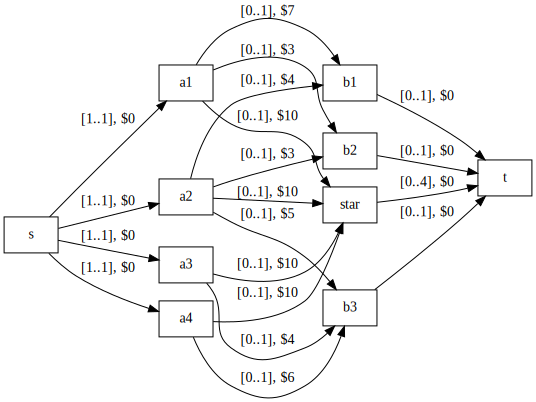

In [15]:
fN3 = nx.DiGraph()

for v in G3.nodes():
    fN3.add_node(v)

# Adding the global source and sink
fN3.add_node('s')
fN3.add_node('t')
    
for v in assembledSeqs:
    fN3.add_edge('s', v, l=1, u=1, c=0)
    

for (u,v) in G3.edges():
    fN3.add_edge(u, v, l=0, u=1, c=(G3[u][v]['cost']))
    

for v in referenceSeqs:
    if v== 'star':
        fN3.add_edge(v, 't', l=0, u=len(assembledSeqs), c=0)
    else:
        fN3.add_edge(v, 't', l=0, u=1, c=0)
    

fN3_dot = network2dot(fN3)
fN3_dot

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 5</strong></h3>

To obtain the optimum matching between the assembled sequences and the references (including 'star') sequences, we must find a min-cost flow on `fN3`, and then recover the matching solution. 

Compute a min-cost flow (using function `min_cost_flow`). Recover the matching as those edges of `G3` which have flow value equal to 1. Print these matching edges.

In [16]:
weight, flow = min_cost_flow(fN3, 's', 't')
#print(weight)

for a in assembledSeqs:
    for node, value in flow[a].items():
        if value == 1:
            print(f'{a} matched with {node}')

a1 matched with b2
a2 matched with b1
a3 matched with b3
a4 matched with star


# 3. RNA assembly as Minimum Path Cover

Having gotten used with min-cost flow reductions, we now apply them to assemble RNA transcripts from splicing graphs. 

## 3.1 Helper functions

We start by loading the graph `splicing_graph.edgelist`. This is created from human transcript annotation, and the node labels, strings of the form '(x,y)', correspond to exons, where x and y are the starting and ending positions of the exon, respectively, in the human reference. In this notebook, we are not interested in the actual bases of the exon.

Directed acyclic graph: True


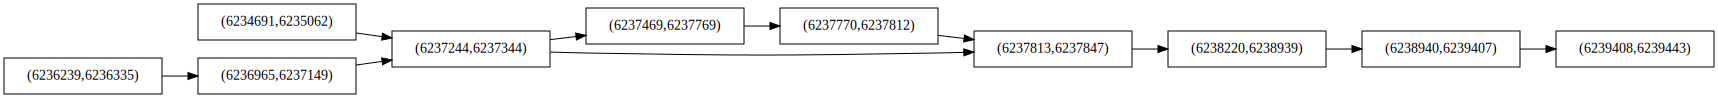

In [17]:
fg = open("data/splicing_graph.edgelist", "rb")
G4 = nx.read_edgelist(fg, create_using=nx.DiGraph)
fg.close()

# We test that the splicing graph is indeed acyclic
print('Directed acyclic graph: ' + str(nx.is_directed_acyclic_graph(G4)))

# Then we visualize the graph
G4_dot = graph2dot(G4)
G4_dot

To have an idea of how our different RNA assembly models (and algorithms) behave, we also provide the *true* RNA transcripts for this graph. We can read them as follows.

In [18]:
from json import load

ft = open("data/true_transcripts.json", "rb")
true_transcripts = [[f'({v[0]},{v[1]})' for v in path] for path in load(ft)]
ft.close()

for transcript_path in true_transcripts:
    print(transcript_path)

['(6234691,6235062)', '(6237244,6237344)', '(6237469,6237769)', '(6237770,6237812)', '(6237813,6237847)', '(6238220,6238939)', '(6238940,6239407)']
['(6237770,6237812)', '(6237813,6237847)', '(6238220,6238939)', '(6238940,6239407)', '(6239408,6239443)']
['(6236239,6236335)', '(6236965,6237149)', '(6237244,6237344)', '(6237813,6237847)', '(6238220,6238939)']


However, it would be much more useful to have a visual representation of these paths. Let's write another visualization function, that prints both the graph (with default black edges), and each path, with a different color.

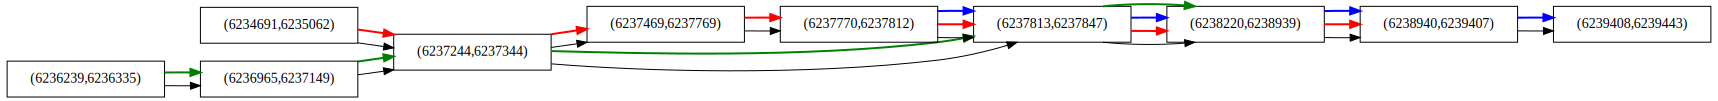

In [19]:
def graphpaths2dot(nxDigraph, paths, pathWeights=None):
    colors = ['red','blue','green','purple','brown']

    dot = Digraph()
    dot.graph_attr['rankdir'] = 'LR' # Display the graph in landscape mode
    dot.node_attr['shape'] = 'rectangle' # Rectangle nodes

    for (u,v) in nxDigraph.edges():
        dot.edge(str(u),str(v)) 
         
    for index, path in enumerate(paths):
        pathColor = colors[index % len(colors)]
        if pathWeights is None:
            dot.attr('edge', color=pathColor, penwidth='2.0')
        else:
            dot.attr('edge', label=str(pathWeights[index]), fontcolor=pathColor, color=pathColor, penwidth='2.0')
        
        
        # If a path has only one node, color that node
        if len(path) == 1:
            dot.node(str(path[0]), color=pathColor, penwidth='2.0')
        else:    
            for i in range(len(path)-1):
                dot.edge(str(path[i]), str(path[i+1]))
     
    return dot

G4_paths_dot = graphpaths2dot(G4, true_transcripts)
G4_paths_dot

## 3.2 Minimum Path Cover model

In this section we will model the RNA transcript assembly problem as a minimum path cover, which we will solve with a min-cost flow reduction.

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 6</strong></h3>

Implement the reduction from minimum path cover to min-cost flow. 

Recall that:
- We replace each node $v$ with two nodes $v_0$ and $v_1$, and an edge $(v_0,v_1)$.
- The edges entering an original node $v$ now enter $v_0$, and the edges exiting an original node $v$ now exit $v_1$.
- We add a global source $s$ with edges to all $0$-nodes, and a global sink $t$, with edges from every $1$-node.
- The cost of the edges out-going from $s$ is $1$, the cost of all other edges is $0$.
- The lower bound is $1$ for all new edges of the form $(v_0,v_1)$, and is $0$ for all other edges.
- You can set the upper bounds of all edges to $\infty$ (use the global variable `bigNumber` defined at the begining of the notebook).

Fill in the missing code fragment.

[('(6234691,6235062)', '(6237244,6237344)'), ('(6237244,6237344)', '(6237469,6237769)'), ('(6237244,6237344)', '(6237813,6237847)'), ('(6237469,6237769)', '(6237770,6237812)'), ('(6237813,6237847)', '(6238220,6238939)'), ('(6237770,6237812)', '(6237813,6237847)'), ('(6238220,6238939)', '(6238940,6239407)'), ('(6238940,6239407)', '(6239408,6239443)'), ('(6236239,6236335)', '(6236965,6237149)'), ('(6236965,6237149)', '(6237244,6237344)')]


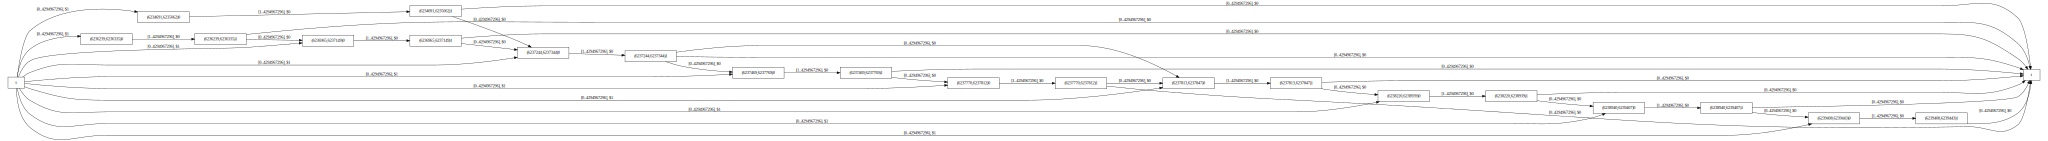

In [44]:
fN4 = nx.DiGraph()

print(G4.edges())

# We add the two nodes corresponding to each node
for v in G4.nodes():
    fN4.add_node(v + '0')
    fN4.add_node(v + '1')

for e0, e1 in G4.edges():
    from_node = f'{e0}1'
    to_node = f'{e1}0'
    fN4.add_edge(from_node, to_node, l=0, u=bigNumber, c=0)
    
fN4.add_node('s')
fN4.add_node('t')

for v in fN4.nodes:
    exon = v[:-1]
    appendix = v[-1]
    if appendix == '0':
        fN4.add_edge('s', v, l=0, u=bigNumber, c=1)
        node1 = f'{exon}1'
        fN4.add_edge(v, node1, l=1, u=bigNumber, c=0)        
    if appendix == '1':
        fN4.add_edge(v, 't', l=0, u=bigNumber, c=0)

fN4_dot = network2dot(fN4)
fN4_dot

In [45]:
flowCost4, flowDict4 = min_cost_flow(fN4, 's', 't')

print(F'The minimum number of paths covering all nodes is {flowCost4}')

The minimum number of paths covering all nodes is 2


## 4. Decomposing a flow into paths

**For this section, please watch the videos for lecture 2.4 (especially videos 3 & 4)**

As you see and realize from the above, the flow values alone do not give the paths (and thus the transcripts). However, any flow in a directed acyclic graph can be decomposed into a collection of weighted paths. As we've seen in the video lectures, finding the *minimum* number of such weighted paths is an NP-hard problem (thus unlikely to be solved efficiently). Moreover, we studied a heuristic for it, namely the one always choosing an $s$-$t$ path of maximum **bottleneck**.

The interesting part about the minimum path cover reduction, is that *any* path decomposition of the resulting min-cost flow will correspond to a flow decomposition into a minimum number of paths, and each such path will have weight 1. However, since we will also use the maximum bottleneck heuristic as a model of RNA transcript assembly, we implement it here.

## 4.1 DP for finding a path of maximum bottleneck

In this section we implement the DP algorithm from the video lectures, which, given a flow, finds an $s$-$t$ path of maximum bottleneck.

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 7</strong></h3>

Explain the following code (both for computing the B values, and for recovering the path of maximum bottleneck). Function `maxBottleckPath` assumes that input `flowNetwork` represents a flow network (DAG with single source `'s'` and single sink `'t'`) and that input `flowDict` defines a non-negative flow $f(e) \ge 0$ for all edges $e \in E$. 

In [46]:
def maxBottleckPath(flowNetwork, flowDict):
    B = dict()
    maxInNeighbor = dict()

    # Computing the B values with DP
    for v in nx.topological_sort(flowNetwork):
        if v == 's':
            B[v] = bigNumber
        else:
            B[v] = -bigNumber
            for u in flowNetwork.predecessors(v):
                uBottleneck = min(B[u], flowDict[u][v])
                if uBottleneck > B[v]:
                    B[v] = uBottleneck 
                    maxInNeighbor[v] = u
    
    
    
    # If no s-t flow exists in the network
    if B['t'] == 0:
        return None, None
    
    # Recovering the path of maximum bottleneck
    reverse_path = ['t']
    while reverse_path[-1] != 's':
        reverse_path.append(maxInNeighbor[reverse_path[-1]])
    
    return B['t'], list(reversed(reverse_path))

---
#### maxBottleckPath

**Computing B values:**
The nodes of flowNetwork are gone through in topological order. The bottleneck of the first node (s) is initialized as infinite (bigNumber) and the for the rest of the nodes (v) the following process is done. First its bottleneck (B[v]) is initialized as minus infinity (-bigNumber) to ensure it will be smaller than any comparison. Then the in-neighbors (u) of the node are looped over and the bottleneck (uBottleneck) from each is calculated as the minumun of the bottleneck to the previous node (B[u]) and the flow from the the previous node to the current node (flowDict[u][v]). Then the current value of the bottleneck to the current node (V[v], intitially minus infinity) is compared to the calculated bottleneck (uBottleneck) and updated if the new bottleneck is greater than the original. Also the dictionary maxInNeaighbor is updated to keep track of the neighbor producing the max bottleneck.

**Recovering the path of max bottleneck:**
After calculating the max bottlenecks with the previous loop, the existence of a flow is checked by seeing if the max bottleneck in the sink is zero. If not, a reverse path is created as follows. A list is initialized with the sink (t) and then the maxInNeighbor dictionary is looped through by appending the reverse_path list with the value of the dictionary in the last node of the list. The loop stops when the source node has been added to the list. Finally, the list is reversed and the max bottleneck path returned togehter with the max bottleneck value.

---

Let's now compute and visualize the path of maximum bottleneck of `fN4`. Again, as mentioned above, all paths will have weight $1$. In the next section, we will see an example where these paths have maximum bottleneck of various weights.

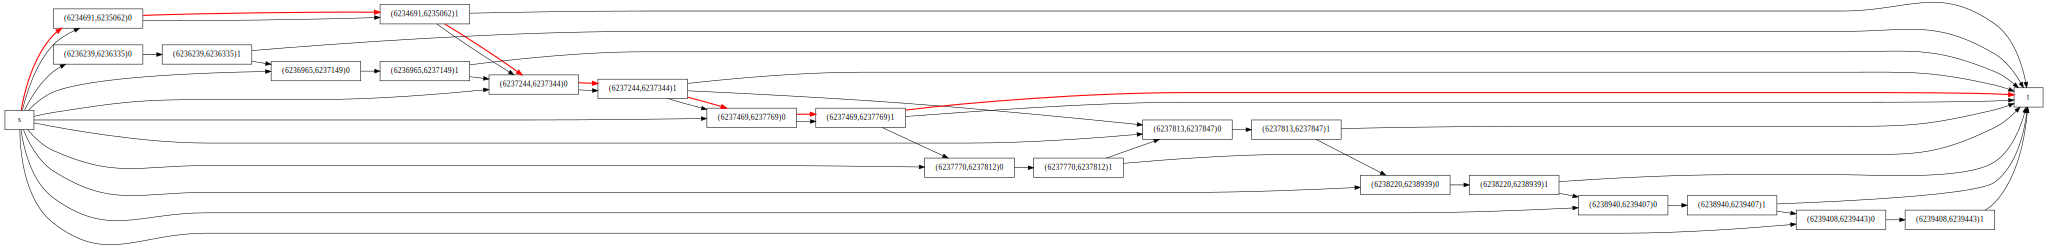

In [47]:
maxBottleneck, maxBottleneckPath = maxBottleckPath(fN4, flowDict4)

fN4_max_bottleneck_path_dot = graphpaths2dot(fN4, [maxBottleneckPath])
fN4_max_bottleneck_path_dot

## 4.2. Decomposing a flow, one path at a time

In this section, we implement a function that iteratively finds a path of maximum bottleneck, and removes it from the flow.

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 8</strong></h3>

Explain the following code.

In [48]:
import copy

def decompose(flowNetwork, flowDict):
    pathDecomposition = list()
    pathWeights = list()
    # Making a copy of flowDict, otherwise the changes we make in this function 
    # will carry over to the global variable flowDict
    tempFlow = copy.deepcopy(flowDict)

    
    while True:
        bottleneck, path = maxBottleckPath(flowNetwork, tempFlow)
        if path is None:
            break
            
        for i in range(len(path)-1):
            tempFlow[path[i]][path[i+1]] -= bottleneck
        
        pathDecomposition.append(path)
        pathWeights.append(bottleneck)
        
    return pathDecomposition, pathWeights

---
#### decompose

First the pathDevomposition and pathWeights lists are initialized and flowDict deepcopied into tempFlow dictionary. Then the flow network is looped over and the max bottleneck is substracted from the max bottleneck path until the max bottleneck flow in the sink is zero. This is done by calculating max bottleneck and its path each round with updated flow dictionary (tempFlow), from each edge of which the max bottleneck value is substracted. Every round the path is added to the pathDecomposition list and the bottleneck value added to the pathWeights list. These list are returned, when the loop stops.

---

Let's check (visually) that in our example we obtain as many paths as the min-cost flow value (i.e. 2 in this case), and that the paths indeed cover all edges of the form $(v_0, v_1)$, meaning that they cover all initial nodes of the graph.

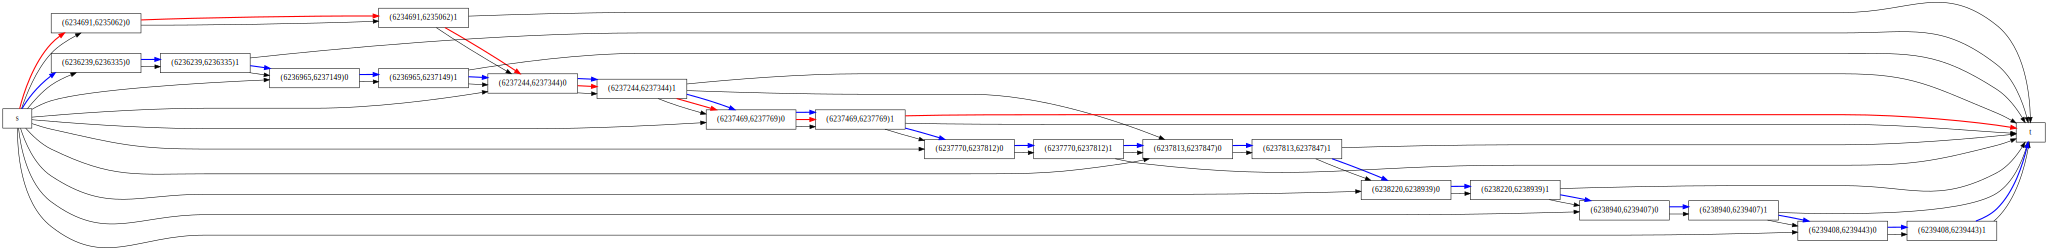

In [49]:
decomposedPaths4, pathWeights4 = decompose(fN4, flowDict4)

fN4_decomposed_dot = graphpaths2dot(fN4, decomposedPaths4)
fN4_decomposed_dot


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 9</strong></h3>

Fill in the code fragment below to convert `decomposedPaths` back into paths of the original graph `G4`. That is, remove `s` and `t` from them, and replace all nodes of the form $v_0,v_1$ back to $v$.

We assembled 2 paths


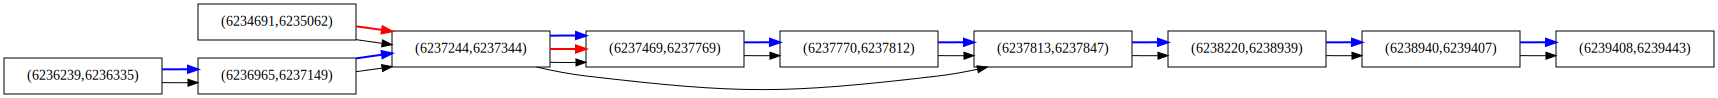

In [53]:
def convertPaths(paths):
    convertedPaths = list()

    for path in paths:
        convertedPath = list()

        for node in path:
            if node != 's' and node != 't':
                new_node = node[:-1]
                if new_node not in convertedPath:
                    convertedPath.append(new_node)
        
        convertedPaths.append(convertedPath)
    return convertedPaths

convertedPaths4 = convertPaths(decomposedPaths4)
print('We assembled {} paths'.format(len(convertedPaths4)))
G4_decomposed_dot = graphpaths2dot(G4, convertedPaths4)
G4_decomposed_dot

Finally, we have a solution to the minimum path cover problem on `G4`. Let's compare it with the true transcripts (computed also above).

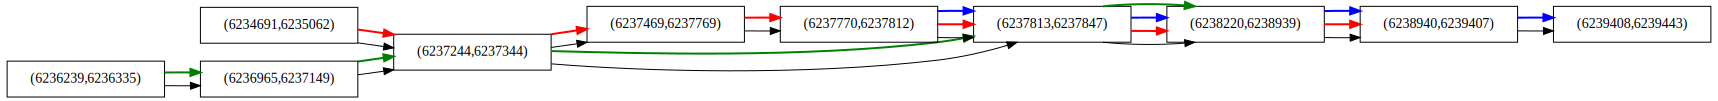

In [ ]:
G4_paths_dot = graphpaths2dot(G4, true_transcripts)
G4_paths_dot

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 10</strong></h3>

Comparing the two sets of transcripts visualized here above, explain in what respects the minimum path cover formulation is not a satisfactory model of RNA assembly.

---
#### Minimum path cover formulation limitations

In our case, the minimum paht cover algorithm found two paths, where the true number was three. The main problem is that, as the name suggests, the minimum path cover algorithm find the minumum number of paths covering the sequences. Here the sequences had some overlap, and therefore the olgorithm was able to find a coverage with less paths than the true solution. The model being strictly mathematical, it just minimizes the number of paths needed for coverage without considering any biological context.

---

# 5. RNA assembly as flow decomposition

Let us now bring in coverage values in the game, and let's implement the last model of RNA assembly discussed in the lecture. Namely, we assume that the coverage values form a flow, and we are looking for a decomposition of it into the minimum number of paths. For simplicity (in order to avoid spliting each node $v$ into $v_0$ and $v_1$), here we assume that only edges have read coverages.

As we discussed at the lecture, solving this problem optimally is NP-hard. As such, we will employ here the heuristic implemented above, that at every steps removes the path of maximum bottleneck.

Let's start by visualizing the coverage values of each edge.

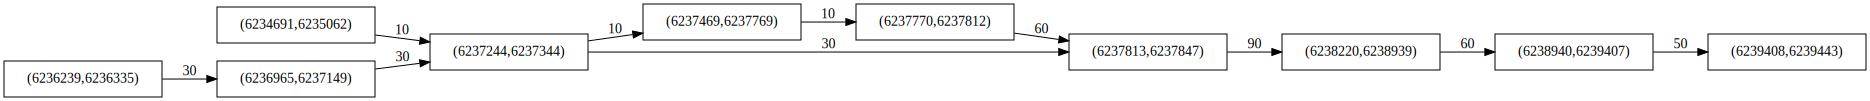

In [58]:
G4_coverage_dot = graph2dot(G4, edgeLabels='coverage')
G4_coverage_dot

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 11</strong></h3>

Comparing the coverage values above, and the true transcripts for this graph, what are the true coverage values of each of the three transcripts? 

---
#### transcript 1 (red)
10+10+10+60+90+60=240

#### transcript 2 (blue)
60+90+60+50=260

#### transcript 3 (green)
30+30+30+90=180

---

At the lecture, we said that from the input coverage values, we construct a flow network as follows.

- We say that a node is a **candidate transcript start** if it has more out-going flow than in-coming flow. Namely, if the sum of coverage values of out-going edges is strictly greater than the sum of coverage values of in-coming edges.
- We say that a node is a **candidate transcript end** if it has more in-going flow than out-coming flow. Namely, if the sum of coverage values of in-going edges is strictly greater than the sum of coverage values of out-coming edges.

With this classification of nodes, we proceed as follows:
- We add each node and each edge of the graph to the flow network, with flow value equaling its coverage.
- We add a global source `s` and a global sink `t`.
- For every node `v` that is a candidate transcript start, we add the edge `(s,v)` with flow value equal to the sum of the out-going flow of `v` *minus* the sum of the in-coming flow of `v`.
- For every node `v` that is a candidate transcript end, we add the edge `(v,t)` with flow value equal to the sum of the in-coming flow of `v` *minus* the sum of the out-going flow of `v`.

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 12</strong></h3>

Let's build this network, call it `fN5`.

**NOTE**: Here, you don't need to set `l`, `u` and `c` values for each edge of the network, since we will not solve a min-cost flow problem on it. Instead, we will also construct a dictionary `flowDict5` storing the flow value mentioned above, so that we can call our function `decompose(fN5, flowDict5)`.

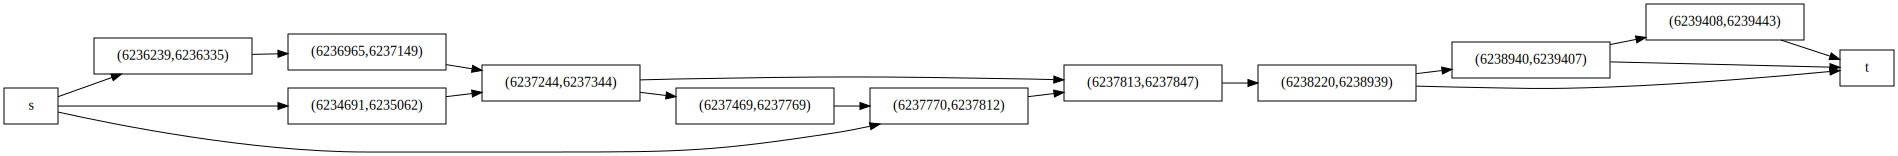

In [70]:
fN5 = nx.DiGraph()

# We implement two functions testing if a node v is a candidate transcript start or end
def isCandidateStart(G,v):
    in_flow = sum([G[u][v]['coverage'] for u in G.predecessors(v)])
    out_flow = sum([G[v][w]['coverage'] for w in G.successors(v)])
    return (out_flow > in_flow), out_flow - in_flow

def isCandidateEnd(G,v):
    in_flow = sum([G[u][v]['coverage'] for u in G.predecessors(v)])
    out_flow = sum([G[v][w]['coverage'] for w in G.successors(v)])
    return (out_flow < in_flow), in_flow - out_flow

# We introduce the global source and sink
fN5.add_node('s')
fN5.add_node('t')

# We initialize the flowDict
flowDict5 = dict()
flowDict5['s'] = dict()
for v in G4.nodes():
    fN5.add_node(v)
    flowDict5[v] = dict()

# Implement the rest of the flow network
# Fill in the missing code fragments

for (u,v) in G4.edges():
    fN5.add_edge(u, v)
    flowDict5[u][v] = G4[u][v]['coverage']

for v in G4.nodes():
    fN5.add_node(v)
    # Your code here
    cand_start, diff1 = isCandidateStart(G4, v)
    cand_end, diff2 = isCandidateEnd(G4, v)

    if cand_start:
        fN5.add_edge('s', v)
        flowDict5['s'][v] = diff1

    if cand_end:
        fN5.add_edge(v, 't')
        flowDict5[v]['t'] = diff2

fN5_dot = graph2dot(fN5)
fN5_dot

Let us now decompose `fN5` and `flowDict5` that you have built above using the heuristic of always selecting the path of maximum bottleneck. 

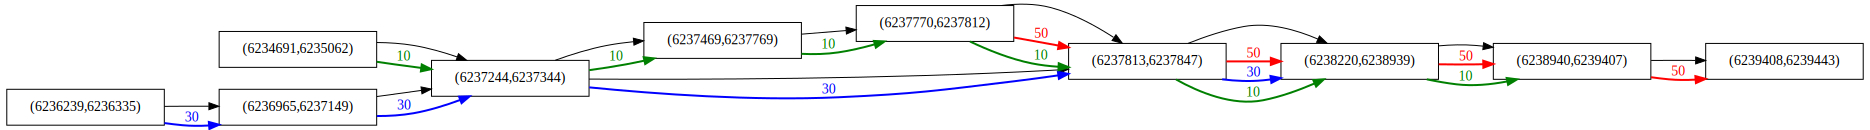

In [71]:
# We implement a simpler version of the above function `convertPaths`
# that just removes s and t from each path
def convertPaths_simple(paths):
    return [path[1:-1] for path in paths]

decomposedPaths5, pathWeights5 = decompose(fN5, flowDict5)
convertedPaths5 = convertPaths_simple(decomposedPaths5)

G5_decomposed_dot = graphpaths2dot(G4, convertedPaths5, pathWeights5)
G5_decomposed_dot

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 13</strong></h3>

- Are the paths resulting from the flow decomposition the same as the true transcripts? What about their coverage values (i.e. weights) retrieved from the flow?
- Describe what are the strong and weak points of this model of RNA assembly

Let's visualize the true transcript here again, for convenience.

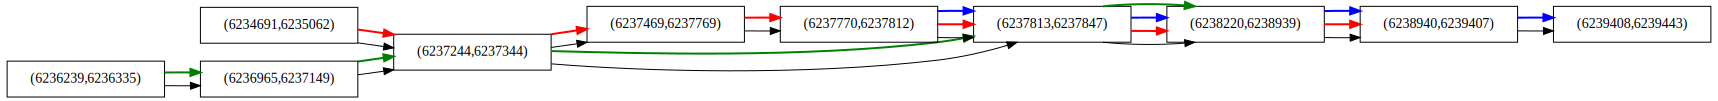

In [72]:
G4_paths_dot = graphpaths2dot(G4, true_transcripts)
G4_paths_dot

---
#### Path cover with coverage values

Now the decomposed paths match the true trascripts, as well as the coverage values. With the help of the coverage, the paths with higher number of reads were prioritized rather than just finding the mimimun number of paths. This time that was enough to get the accurate result. However, with more overlaps and perhaps more bias even this method would not necessarily produce the correct paths. 

---